In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from tqdm import tqdm
from matplotlib import pyplot as plt

# Question 2 - Clustering

In [67]:
dt = pd.read_csv('Reviews.csv', sep=",", usecols = [i for i in range(1,10)])

In [70]:
dt.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [71]:
dt.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


## Clean up data

In [72]:
dt = dt.drop_duplicates(subset=["UserId","ProfileName","Time","Text"], keep='first', inplace=False)
dt = dt[dt["HelpfulnessNumerator"] <= dt["HelpfulnessDenominator"]] # remove the numerator greater than denominator

In [73]:
dt.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,393931.000000,393931.000000,393931.000000,3.939310e+05
mean,1.734393,2.204805,4.179397,1.296449e+09
std,6.872280,7.534791,1.311927,4.840344e+07
min,0.000000,0.000000,1.000000,9.393408e+08
25%,0.000000,0.000000,4.000000,1.271376e+09
50%,0.000000,1.000000,5.000000,1.311638e+09
75%,2.000000,2.000000,5.000000,1.332979e+09
max,866.000000,923.000000,5.000000,1.351210e+09


In [74]:
dt.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
dtype: int64

There is a very few number of null values. Let's fill them:

In [75]:
dt['ProfileName'].fillna('', inplace=True)
dt['Summary'].fillna('', inplace=True)

In [76]:
dt.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Tokenize the text 

In [77]:
product_id = []
summary = []
reviews = []
new_df = pd.DataFrame()
for product, group in dt.groupby('ProductId'):
    product_id.append(product)
    reviews.append(" ".join(list(group['Text'])))
    summary.append(" ".join(list(map(str,group['Summary']))))
    
new_df['ProductId'] = product_id
new_df['reviews'] = reviews
new_df['summary'] = summary

In [78]:
def clean_text(text):
    stop_words = set(stopwords.words('english')) # obtain the stop words
    good_words = [] # save the correct words to consider like tokens
    tokenizer = RegexpTokenizer("[\w']+") # function to recognize the tokens
    words = tokenizer.tokenize(text) # tokenize the text 
    for word in words:
        # check if the word is lower and it isn't a stop word or a number
        if word.lower() not in stop_words and word.isalpha(): 
            word = PorterStemmer().stem(word) # use the stemmer function
            good_words.append(word.lower()) # insert the good token to lower case
        
    return good_words

In [79]:
%%time
# use the interest column..
new_df["reviews"] = [clean_text(x) for x in list(new_df["reviews"])]
new_df.head()

Wall time: 8min 8s


,ProductId,reviews,summary
0,0006641040,"[day, person, say, chicken, soup, probabl, go,...",Read it once. Read it twice. Reading Chicken S...
1,141278509X,"[product, archer, farm, best, drink, mix, ever...",The best drink mix
2,2734888454,"[dog, love, chicken, product, china, wont, buy...",made in china Dog Lover Delites
3,2841233731,"[book, easi, read, ingredi, avail, store, unli...",Great recipe book for my babycook
4,7800648702,"[came, huge, tin, much, bigger, expect, cooki,...","Delicious Mildly Sweet Cookie Lots of crispy, ..."


In [80]:
new_df.head()

,ProductId,reviews,summary
0,0006641040,"[day, person, say, chicken, soup, probabl, go,...",Read it once. Read it twice. Reading Chicken S...
1,141278509X,"[product, archer, farm, best, drink, mix, ever...",The best drink mix
2,2734888454,"[dog, love, chicken, product, china, wont, buy...",made in china Dog Lover Delites
3,2841233731,"[book, easi, read, ingredi, avail, store, unli...",Great recipe book for my babycook
4,7800648702,"[came, huge, tin, much, bigger, expect, cooki,...","Delicious Mildly Sweet Cookie Lots of crispy, ..."


In [81]:
%%time

tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, min_df = 0.007)
tfidf_matrix = tfidf.fit_transform(new_df["reviews"])

Wall time: 7.05 s


In [82]:
%%time
len(tfidf.vocabulary_)

Wall time: 0 ns


2145

In [83]:
%%time
dn = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)

Wall time: 916 ms


In [84]:
dn

,0,1,2,3,4,5,6,7,8,9,...,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144
0,0.0,0.013143,0.006529,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01042,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.191621,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67619,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
67620,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
67621,0.0,0.000000,0.000000,0.310321,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
67622,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [85]:
svd = TruncatedSVD(n_components=500)
new_dn = svd.fit_transform(dn)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum()*100)

[0.01225097 0.02416933 0.017116   0.01319098 0.01121082 0.0099161
 0.00845543 0.00751402 0.00657727 0.00607779 0.00569094 0.00540802
 0.00502597 0.00475972 0.00462845 0.00448364 0.004369   0.00416698
 0.00407483 0.00390722 0.00381671 0.00379346 0.003725   0.00365696
 0.00358626 0.00352749 0.00344236 0.00336808 0.00328392 0.0032619
 0.00315086 0.00307065 0.00301155 0.00300747 0.00293777 0.00287081
 0.00280864 0.00273847 0.00271331 0.00264312 0.00262618 0.00260007
 0.00253811 0.00252501 0.00249779 0.00247378 0.00245269 0.00242529
 0.00237948 0.00235756 0.00233748 0.0023113  0.00228742 0.00224037
 0.00223552 0.00219468 0.00217568 0.00214275 0.00211017 0.00209436
 0.00208848 0.00206813 0.00204638 0.00202562 0.00201054 0.00199971
 0.00198382 0.00194974 0.00194219 0.00190902 0.00189122 0.00187066
 0.00185068 0.00183447 0.00182952 0.00182238 0.00180169 0.00178822
 0.00178473 0.00177322 0.00177092 0.00175288 0.00172411 0.00170504
 0.00170301 0.00170062 0.00168302 0.00167109 0.00166248 0.001645

In [94]:
new_dn

array([[ 0.257116  , -0.06749298, -0.05110632, ..., -0.0013427 ,
         0.01738826,  0.01103389],
       [ 0.17181801, -0.01651118, -0.01033533, ..., -0.01643824,
         0.03058823, -0.01373597],
       [ 0.15338822, -0.07084431, -0.09246994, ..., -0.00244751,
        -0.03443211,  0.01565376],
       ...,
       [ 0.18807876, -0.01159982,  0.14484697, ...,  0.0030966 ,
         0.01750949,  0.00545587],
       [ 0.17486906, -0.06080003, -0.04668805, ..., -0.0093387 ,
         0.00644224,  0.00713878],
       [ 0.12254261, -0.03368386, -0.01112219, ..., -0.01432363,
        -0.04880088, -0.02214174]])

## Elbow Method

This can be useful for the second bonus point

In [111]:
#elbow = {}
for k in tqdm(range(35,45,2)):
    elbow_model = KMeans(n_clusters=k)
    elbow_model.fit_predict(slice)
    elbow[k] = elbow_model.inertia_ 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:59<00:00, 95.94s/it]


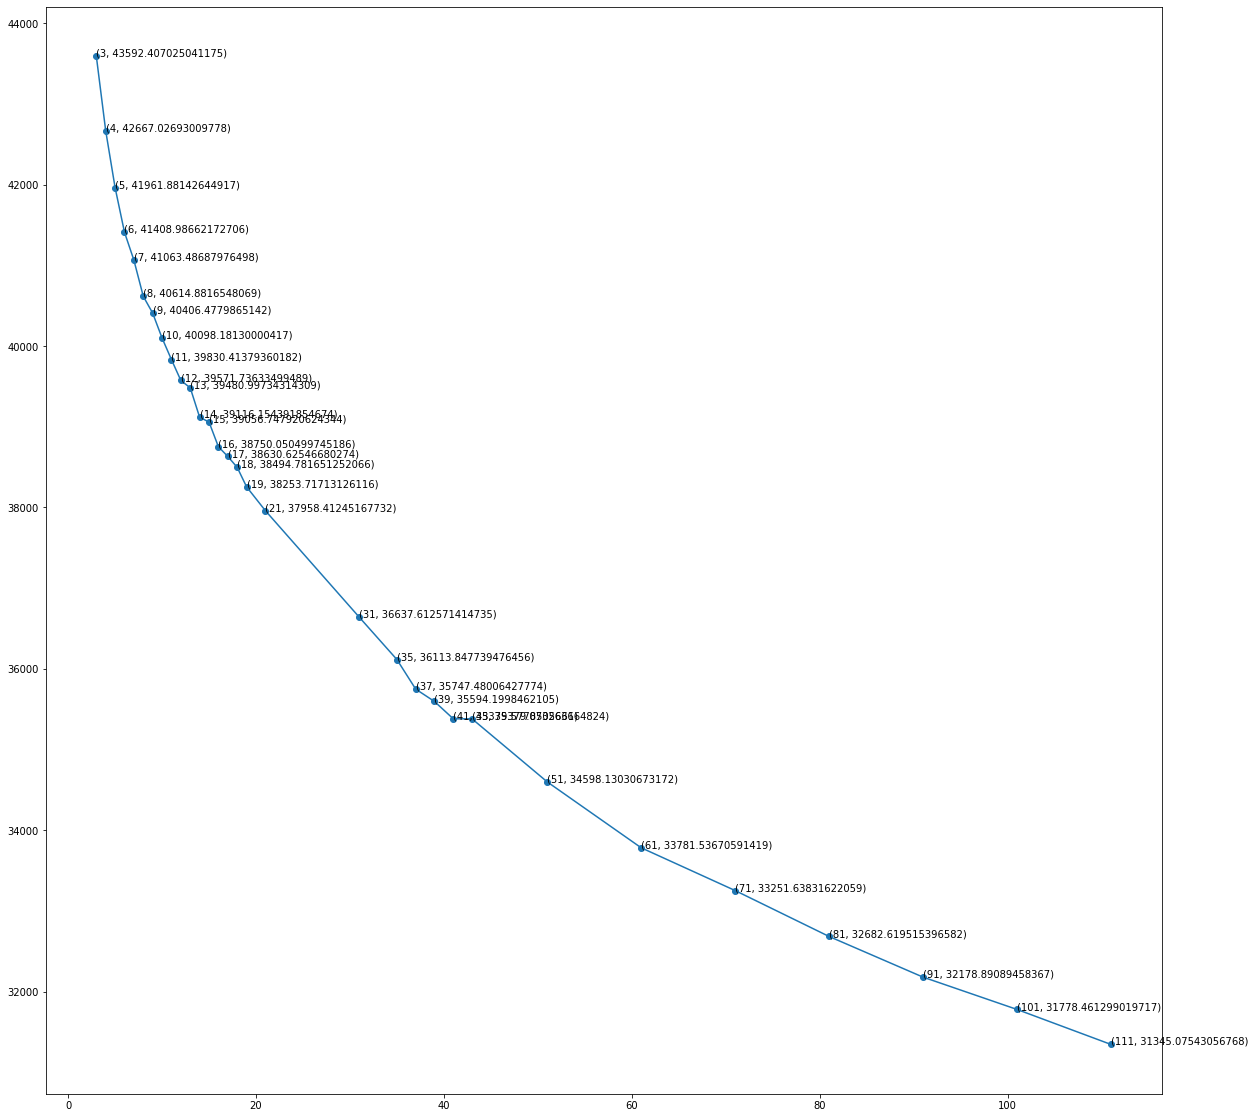

In [137]:
plt.figure(figsize=(20,20))
plt.plot(sorted(list(elbow.keys())), sorted(list(elbow.values()), reverse= True), marker='o')

for x,y in zip(sorted(list(elbow.keys())),sorted(list(elbow.values()), reverse= True)):

    label = f"({x},{y})"

    plt.annotate(xy = (x,y), text = (x,y))

In [127]:
elbows


{3: 43592.407025041175,
 4: 42667.02693009778,
 5: 41961.88142644917,
 6: 41408.98662172706,
 7: 41063.48687976498,
 8: 40614.8816548069,
 9: 40406.4779865142,
 10: 40098.18130000417,
 11: 39830.41379360182,
 12: 39571.73633499489,
 13: 39480.99734314309,
 14: 39116.154391854674,
 15: 39056.747920624344,
 16: 38750.050499745186,
 17: 38630.62546680274,
 18: 38494.781651252066,
 19: 38253.71713126116,
 21: 37958.41245167732,
 31: 36637.612571414735,
 41: 35379.073263664824,
 51: 34598.13030673172,
 61: 33781.53670591419,
 71: 33251.63831622059,
 81: 32682.619515396582,
 91: 32178.89089458367,
 101: 31778.461299019717,
 111: 31345.07543056768,
 35: 36113.847739476456,
 37: 35747.48006427774,
 39: 35594.1998462105,
 43: 35379.5778505661}

## K-Means algorithm

In [111]:
def calc_distance(X1, X2):
    return np.sqrt(sum((X1 - X2)**2))
l=np.array([1,3,4])
m = np.array([[1,1,1],[1,8,9]])

j = np.argmin([np.array([calc_distance(l, m_j) for j,m_j in enumerate(m)])])
cluster[j].append(x)

0

In [263]:
from collections import defaultdict

def calc_distance(X1, X2):
    return np.sqrt(sum((X1 - X2)**2))

def initialization(k):
    return np.random.uniform(0, 1, [k])

def Assign_Cluster(new_dn, k):    
    centroids = initialization(k)
    clusters = defaultdict(list)
    for i, x in enumerate(new_dn):
        centroid = np.argmin([np.array([calc_distance(x, mu_j) for j,mu_j in enumerate(centroids)])])
        if centroid:
            clusters[centroid].append(x)
    
    return clusters

def update_centroid(centroids,clusters,k):
    upd_c = np.array([np.mean(clusters[i]) if i in clusters.keys() else centroids[i] for i in range(k)])
    return upd_c

In [246]:
%%time
c = Assign_Cluster(new_dn, 5)

Wall time: 26.9 s


In [266]:
%%time
update_centroid(initialization(5), c, 5)

Wall time: 313 ms


array([2.19489724e-01, 3.87282474e-01, 2.08077635e-01, 8.30284909e-01,
       4.65089062e-04])

In [227]:
c.keys()

dict_keys([0])

In [199]:
model = KMeans(n_clusters = 100)

TypeError: KMeans() got an unexpected keyword argument 'n_clusters'

In [95]:
slice = new_dn[:] # only column 3 to 6

In [59]:
model.fit(slice)

KMeans(n_clusters=100)

In [60]:
cluster = model.predict(slice)

In [61]:
cluster

array([78, 25, 62, ..., 16, 11, 25])

In [70]:
new_dataframe = pd.DataFrame()
new_dataframe['ProductId'] = new_df['ProductId']
new_dataframe['Cluster'] = cluster

In [66]:
dt.loc[(dt['ProductId'] == 'B009UOFU20') | (dt['ProductId'] == 'B009UOFTUI')]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1477,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,1,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w..."
191720,B009UOFTUI,AJVB004EB0MVK,D. Christofferson,0,0,1,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w..."


In [93]:
new_dataframe.groupby('Cluster').count().sort_values(by='ProductId')
lista = new_dataframe.loc[new_dataframe['Cluster'] == 52]
lista2 = lista['ProductId']
new_df.loc[new_df['ProductId'].isin(lista2)]

,ProductId,reviews,summary
170,B00008GKAV,"[food, compet, garbag, main, ingredi, corn, un...",One of the worst dog foods Unhealthy for your dog
182,B00008O36H,"[two, golden, retriev, bene, weight, control, ...",Great for our dogs! unless you want to pick do...
329,B0000CET6I,"[bought, dog, food, bag, show, pictur, veggi, ...","False Advertising, Terrible Dog Food!! My dog'..."
4823,B0006345MA,"[use, brand, year, get, via, amazon, sub, save...","Dog loves this food False Advertising, Terribl..."
4867,B000634D0O,"[three, dog, love, cat, steal, littl, piec, ch...","cats even love it! False Advertising, Terrible..."
4868,B000634D0Y,"[bought, dog, food, bag, show, pictur, veggi, ...","False Advertising, Terrible Dog Food!!"
6235,B0009JRUT6,"[bought, dog, food, bag, show, pictur, veggi, ...","False Advertising, Terrible Dog Food!! Sensiti..."
6238,B0009JUQ0Q,"[bought, dog, food, bag, show, pictur, veggi, ...","False Advertising, Terrible Dog Food!!"
7030,B000BOS3E0,"[bought, dog, food, bag, show, pictur, veggi, ...","False Advertising, Terrible Dog Food!!"
13744,B000JOQ3VM,"[bought, dog, food, bag, show, pictur, veggi, ...","False Advertising, Terrible Dog Food!!"


In [33]:
slice['cluster'] = cluster

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Let's plot the results

In [70]:
from matplotlib import pyplot as plt

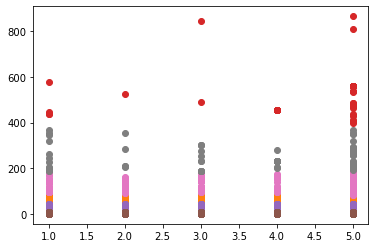

In [71]:
fig = plt.figure()
for cluster in range(0, 10):
    plt.scatter(slice[slice.cluster == cluster].Score, slice[slice.cluster == cluster].HelpfulnessNumerator)
plt.show()

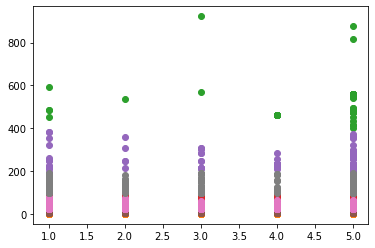

In [72]:
model = KMeans(verbose=False)
slice = dataset.iloc[:,3:6]
model.fit(slice)
cluster_values = model.predict(slice)
dataset['cluster'] = cluster_values
fig = plt.figure()
for cluster in range(0,10):
    plt.scatter(dataset[dataset.cluster == cluster].Score, dataset[dataset.cluster == cluster].HelpfulnessDenominator)
plt.show()

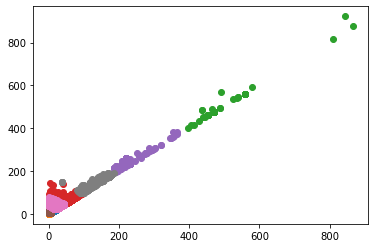

In [73]:
fig = plt.figure()
for cluster in range(0,10):
    plt.scatter(dataset[dataset.cluster == cluster].HelpfulnessNumerator, dataset[dataset.cluster == cluster].HelpfulnessDenominator)
plt.show()

In [74]:
from tqdm import tqdm

In [75]:
slice = dataset.iloc[:,3:6]

In [76]:
elbow = {}
for k in tqdm(range(3,20)):
    elbow_model = KMeans(n_clusters=k)
    elbow_model.fit_predict(slice)
    elbow[k] = elbow_model.inertia_ 

100%|██████████| 17/17 [01:45<00:00,  6.18s/it]


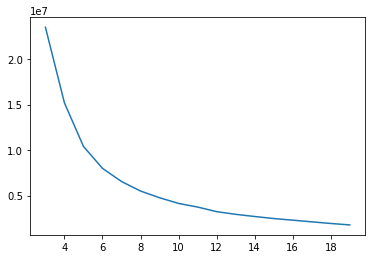

In [77]:
plt.plot(list(elbow.keys()), list(elbow.values()))

In [78]:
products_per_cluster = {}
for cluster in range(0,6):
    products_per_cluster[cluster] = len(dataset[dataset.cluster == cluster].ProductId.unique())

In [79]:
products_per_cluster

{0: 8737, 1: 70219, 2: 36, 3: 807, 4: 75, 5: 26199}

In [80]:
users_per_cluster = {}
for cluster in range(0,6):
    users_per_cluster[cluster] = len(dataset[dataset.cluster == cluster].UserId.unique())

In [81]:
users_per_cluster

{0: 12433, 1: 209663, 2: 20, 3: 729, 4: 49, 5: 53979}

In [82]:
row_per_cluster = {}
for cluster in range(0,6):
    row_per_cluster[cluster] = len(dataset[dataset.cluster == cluster])

In [83]:
row_per_cluster

{0: 19460, 1: 451122, 2: 48, 3: 1236, 4: 86, 5: 91768}